# 基于Yelp评论的餐厅推荐系统情感分析

## 1. 导入必要的库

In [12]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import HeatMap, MarkerCluster
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import os

# 设置中文字体支持（解决matplotlib中文显示问题）
plt.rcParams["font.family"] = ["Times New Roman", "SimSun"]  # 英文字体为新罗马，中文字体为宋体
plt.rcParams["font.serif"] = ["Times New Roman", "SimSun"]  # 衬线字体
plt.rcParams["font.sans-serif"] = ["Times New Roman", "SimSun", "Arial", "SimHei"]  # 无衬线字体，与Latex相关
plt.rcParams["mathtext.fontset"] = "custom"

plt.rcParams['axes.unicode_minus'] = False


## 2. 定义数据路径和常量

In [13]:
# 定义数据路径
DATA_PATH = "D:/必须用电脑解决的作业/地理大数据分析/实习四/实习四数据/yelp/"
BUSINESS_FILE = os.path.join(DATA_PATH, "yelp_academic_dataset_business.json")
REVIEW_FILE = os.path.join(DATA_PATH, "yelp_academic_dataset_review.json")
USER_FILE = os.path.join(DATA_PATH, "yelp_academic_dataset_user.json")
TIP_FILE = os.path.join(DATA_PATH, "yelp_academic_dataset_tip.json")
CHECKIN_FILE = os.path.join(DATA_PATH, "yelp_academic_dataset_checkin.json")

# 目标城市和研究参数
TARGET_CITY = "New Orleans"
SAVE_INTERMEDIATE = True  # 是否保存中间结果
INTERMEDIATE_PATH = "./intermediate_data/"
os.makedirs(INTERMEDIATE_PATH, exist_ok=True)

# 定义餐厅相关类别关键词
RESTAURANT_KEYWORDS = ['restaurant', 'food', 'cafe', 'coffee', 'bar', 'pub', 'diner', 'grill', 'steakhouse', 
                       'pizza', 'italian', 'chinese', 'mexican', 'japanese', 'indian', 'thai', 'vietnamese',
                       'breakfast', 'brunch', 'lunch', 'dinner', 'bakery', 'deli', 'bistro', 'tavern']


## 3. 数据加载和清洗函数

In [14]:
def load_business_data(file_path, target_city=None, is_restaurant=True):
    """
    加载business数据并进行初步过滤
    
    参数:
    file_path: business.json文件路径
    target_city: 目标城市名称，如果为None则加载所有城市
    is_restaurant: 是否只加载餐厅数据
    """
    print(f"开始加载business数据: {file_path}")
    
    # 使用逐行读取的方式加载大JSON文件
    business_data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            try:
                data = json.loads(line.strip())
                business_data.append(data)
            except json.JSONDecodeError:
                print(f"第{i}行JSON解析错误，跳过")
                
            # 进度显示
            if (i + 1) % 50000 == 0:
                print(f"已加载 {i + 1} 条business数据")
    
    print(f"成功加载 {len(business_data)} 条business数据")
    
    # 转换为DataFrame
    business_df = pd.DataFrame(business_data)
    
    # 基础清洗：确保必要字段存在
    required_columns = ['business_id', 'name', 'city', 'state', 'latitude', 'longitude', 'categories']
    missing_columns = [col for col in required_columns if col not in business_df.columns]
    
    if missing_columns:
        print(f"警告：缺失列 {missing_columns}")
        # 添加缺失列（填充空值）
        for col in missing_columns:
            if col == 'categories':
                business_df[col] = business_df.get(col, None)
            else:
                business_df[col] = business_df.get(col, np.nan)
    
    # 过滤目标城市
    if target_city:
        print(f"过滤城市: {target_city}")
        # 处理城市名称大小写和空格问题
        business_df['city_clean'] = business_df['city'].astype(str).str.lower().str.strip()
        target_city_clean = target_city.lower().strip()
        
        # 使用模糊匹配（包含目标城市名）
        city_mask = business_df['city_clean'].str.contains(target_city_clean, na=False)
        business_df = business_df[city_mask].copy()
        print(f"过滤后剩余 {len(business_df)} 条数据（目标城市）")
    
    # 过滤餐厅
    if is_restaurant:
        print("过滤餐厅数据...")
        # 创建餐厅判断函数
        def is_restaurant_func(categories):
            if pd.isna(categories):
                return False
            categories_lower = str(categories).lower()
            for keyword in RESTAURANT_KEYWORDS:
                if keyword in categories_lower:
                    return True
            return False
        
        restaurant_mask = business_df['categories'].apply(is_restaurant_func)
        business_df = business_df[restaurant_mask].copy()
        print(f"过滤后剩余 {len(business_df)} 条餐厅数据")
    
    # 坐标数据清洗
    print("清洗坐标数据...")
    # 移除无效坐标
    business_df = business_df.dropna(subset=['latitude', 'longitude'])
    
    # 移除明显错误的坐标（Null Island, 超出范围等）
    valid_coords_mask = (
        business_df['latitude'].between(-90, 90) &
        business_df['longitude'].between(-180, 180) &
        ~((business_df['latitude'].abs() < 1e-6) & (business_df['longitude'].abs() < 1e-6))  # 排除Null Island附近
    )
    business_df = business_df[valid_coords_mask].copy()
    
    print(f"坐标清洗后剩余 {len(business_df)} 条数据")
    
    # 保存中间结果
    if SAVE_INTERMEDIATE:
        output_file = os.path.join(INTERMEDIATE_PATH, f"business_{target_city.replace(' ', '_')}.csv")
        business_df.to_csv(output_file, index=False)
        print(f"Business数据已保存到: {output_file}")
    
    return business_df

def load_review_data(file_path, business_ids, sample_frac=None):
    """
    加载review数据，只加载指定business_id的评论
    
    参数:
    file_path: review.json文件路径
    business_ids: 需要加载的business_id列表
    sample_frac: 采样比例，如果为None则加载全部
    """
    print(f"开始加载review数据，目标business数量: {len(business_ids)}")
    
    # 将business_ids转换为集合以便快速查找
    business_ids_set = set(business_ids)
    
    # 分块读取review数据
    chunk_size = 50000
    chunks = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        chunk = []
        for i, line in enumerate(f):
            try:
                data = json.loads(line.strip())
                
                # 只保留属于目标business的评论
                if data.get('business_id') in business_ids_set:
                    chunk.append(data)
                    
                    # 如果达到chunk_size，保存并清空
                    if len(chunk) >= chunk_size:
                        chunks.append(pd.DataFrame(chunk))
                        chunk = []
                        print(f"已处理 {i + 1} 行，找到 {len(chunks[-1])} 条相关评论")
                
            except json.JSONDecodeError:
                continue
            
            # 进度显示
            if (i + 1) % 500000 == 0:
                print(f"已扫描 {i + 1} 行review数据")
    
    # 处理最后一个chunk
    if chunk:
        chunks.append(pd.DataFrame(chunk))
    
    # 合并所有chunks
    if chunks:
        review_df = pd.concat(chunks, ignore_index=True)
    else:
        review_df = pd.DataFrame()
    
    print(f"成功加载 {len(review_df)} 条相关review数据")
    
    # 采样（如果需要）
    if sample_frac and sample_frac < 1.0:
        review_df = review_df.sample(frac=sample_frac, random_state=42)
        print(f"采样后剩余 {len(review_df)} 条review数据")
    
    # 保存中间结果
    if SAVE_INTERMEDIATE and len(review_df) > 0:
        output_file = os.path.join(INTERMEDIATE_PATH, f"reviews_filtered.csv")
        review_df.to_csv(output_file, index=False)
        print(f"Review数据已保存到: {output_file}")
    
    return review_df


## 4. 数据预处理和合并

In [15]:
def clean_and_merge_data(business_df, review_df):
    """
    清洗和合并business和review数据
    
    参数:
    business_df: 清洗后的business数据
    review_df: 过滤后的review数据
    """
    print("开始合并business和review数据...")
    
    # 合并数据：先给商家表的stars重命名为business_stars/avg_stars
    merged_df = pd.merge(
    review_df,  # 评论表的stars保留（单条评论评分）
    # 对商家表的列进行筛选+重命名：stars → avg_stars（商家平均评分）
    business_df[['business_id', 'name', 'city', 'state', 'latitude', 'longitude', 
                 'stars', 'review_count', 'categories', 'attributes']].rename(
                columns={'stars': 'avg_stars'} ), # 将business里的stars重命名为avg_stars
 
    on='business_id',
    how='left'
    )
    print(f"合并后数据形状: {merged_df.shape}")
    
    # 处理日期字段
    if 'date' in merged_df.columns:
        merged_df['date'] = pd.to_datetime(merged_df['date'])
        merged_df['year'] = merged_df['date'].dt.year
        merged_df['month'] = merged_df['date'].dt.month
        merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
    
    # 处理有用性字段
    if 'useful' in merged_df.columns:
        merged_df['useful'] = pd.to_numeric(merged_df['useful'], errors='coerce').fillna(0)
    
    if 'funny' in merged_df.columns:
        merged_df['funny'] = pd.to_numeric(merged_df['funny'], errors='coerce').fillna(0)
    
    if 'cool' in merged_df.columns:
        merged_df['cool'] = pd.to_numeric(merged_df['cool'], errors='coerce').fillna(0)
    # 保存合并后的数据
    if SAVE_INTERMEDIATE:
        output_file = os.path.join(INTERMEDIATE_PATH, "merged_data.csv")
        merged_df.to_csv(output_file, index=False)
        print(f"合并数据已保存到: {output_file}")
    
    return merged_df

def load_intermediate_data():
    """
    加载中间数据（如果已经存在）
    """
    business_file = os.path.join(INTERMEDIATE_PATH, f"business_{TARGET_CITY.replace(' ', '_')}.csv")
    reviews_file = os.path.join(INTERMEDIATE_PATH, "reviews_filtered.csv")
    merged_file = os.path.join(INTERMEDIATE_PATH, "merged_data.csv")
    
    if os.path.exists(business_file) and os.path.exists(reviews_file):
        print("加载已保存的中间数据...")
        business_df = pd.read_csv(business_file)
        review_df = pd.read_csv(reviews_file)
        
        if os.path.exists(merged_file):
            merged_df = pd.read_csv(merged_file)
            # 确保日期字段是datetime类型
            if 'date' in merged_df.columns:
                merged_df['date'] = pd.to_datetime(merged_df['date'])
            return business_df, review_df, merged_df
        else:
            # 合并数据
            merged_df = clean_and_merge_data(business_df, review_df)
            return business_df, review_df, merged_df
    else:
        return None, None, None


In [16]:
print("=" * 60)
print(f"开始执行基于Yelp评论的餐厅推荐系统情感分析")
print(f"目标城市: {TARGET_CITY}")
print("=" * 60)

# 尝试加载中间数据
business_df, review_df, merged_df = load_intermediate_data()

if business_df is None or review_df is None:
    print("中间数据不存在，开始原始数据处理...")
    
    # 1. 加载business数据
    business_df = load_business_data(
        BUSINESS_FILE, 
        target_city=TARGET_CITY, 
        is_restaurant=True
    )
    
    if len(business_df) == 0:
        print(f"错误：未找到{TARGET_CITY}的餐厅数据")
        raise Exception("未找到相关数据")
    
    # 2. 加载review数据（只加载相关business的评论）
    business_ids = business_df['business_id'].tolist()
    review_df = load_review_data(
        REVIEW_FILE, 
        business_ids, 
        sample_frac=0.5  # 采样50%以减少处理时间
    )
    
    if len(review_df) == 0:
        print("错误：未找到相关评论数据")
        raise Exception("未找到相关数据")
    
    # 3. 合并数据
    merged_df = clean_and_merge_data(business_df, review_df)

print(f"数据加载完成:")
print(f"  餐厅数量: {len(business_df)}")
print(f"  评论数量: {len(review_df)}")
print(f"  合并数据形状: {merged_df.shape}")

开始执行基于Yelp评论的餐厅推荐系统情感分析
目标城市: New Orleans
加载已保存的中间数据...
数据加载完成:
  餐厅数量: 3343
  评论数量: 270176
  合并数据形状: (270176, 21)


## 5. 情感分析模块

In [17]:
def preprocess_text(text):
    """
    文本预处理函数
    """
    if pd.isna(text):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 移除URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 移除特殊字符和数字
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 移除多余空格
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def analyze_sentiment(text):
    """
    使用TextBlob进行情感分析
    
    返回:
    sentiment_polarity: 情感极性 (-1到1之间)
    sentiment_subjectivity: 情感主观性 (0到1之间)
    """
    if pd.isna(text) or str(text).strip() == "":
        return 0.0, 0.0
    
    try:
        analysis = TextBlob(str(text))
        return analysis.sentiment.polarity, analysis.sentiment.subjectivity
    except:
        return 0.0, 0.0

def batch_sentiment_analysis(df, text_column='text', sample_size=None):
    """
    批量情感分析
    
    参数:
    df: 包含文本的DataFrame
    text_column: 文本列名
    sample_size: 采样大小，如果为None则分析所有数据
    """
    print("开始情感分析...")
    
    # 如果需要采样
    if sample_size and sample_size < len(df):
        df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    else:
        df_sample = df.copy()
    
    # 预处理文本
    print("预处理文本...")
    df_sample['cleaned_text'] = df_sample[text_column].apply(preprocess_text)
    
    # 应用情感分析
    print("应用情感分析...")
    sentiment_results = df_sample['cleaned_text'].apply(
        lambda x: analyze_sentiment(x) if isinstance(x, str) else (0.0, 0.0)
    )
    
    # 分离结果
    df_sample['sentiment_polarity'] = [r[0] for r in sentiment_results]
    df_sample['sentiment_subjectivity'] = [r[1] for r in sentiment_results]
    
    # 情感分类
    def categorize_sentiment(polarity):
        if polarity > 0.1:
            return 'positive'
        elif polarity < -0.1:
            return 'negative'
        else:
            return 'neutral'
    
    df_sample['sentiment_category'] = df_sample['sentiment_polarity'].apply(categorize_sentiment)
    
    # 情感强度分类
    def categorize_sentiment_intensity(polarity):
        if polarity > 0.5:
            return 'very_positive'
        elif polarity > 0.1:
            return 'positive'
        elif polarity < -0.5:
            return 'very_negative'
        elif polarity < -0.1:
            return 'negative'
        else:
            return 'neutral'
    
    df_sample['sentiment_intensity'] = df_sample['sentiment_polarity'].apply(categorize_sentiment_intensity)
    
    print(f"情感分析完成，处理了 {len(df_sample)} 条评论")
    print("情感分布:")
    print(df_sample['sentiment_category'].value_counts())
    
    # 保存结果
    if SAVE_INTERMEDIATE:
        output_file = os.path.join(INTERMEDIATE_PATH, "sentiment_analysis_results.csv")
        df_sample.to_csv(output_file, index=False)
        print(f"情感分析结果已保存到: {output_file}")
    
    return df_sample

def aggregate_restaurant_sentiments(df):
    """
    按餐厅聚合情感数据
    
    返回:
    包含餐厅情感统计的DataFrame
    """
    print("按餐厅聚合情感数据...")
    
    # 确保必要的列存在
    required_cols = ['business_id', 'name', 'sentiment_polarity', 'sentiment_category', 
                     'stars', 'review_count', 'latitude', 'longitude']
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"警告：缺失列 {missing_cols}")
        return pd.DataFrame()
    
    # 按餐厅分组统计
    restaurant_stats = df.groupby(['business_id', 'name', 'stars', 'review_count', 
                                   'latitude', 'longitude', 'categories']).agg({
        'sentiment_polarity': ['mean', 'std', 'count'],
        'sentiment_category': lambda x: (x == 'positive').sum() / len(x) if len(x) > 0 else 0,
        'useful': 'sum',
        'funny': 'sum',
        'cool': 'sum'
    }).reset_index()
    
    # 重命名列
    restaurant_stats.columns = [
        'business_id', 'name', 'stars', 'review_count', 'latitude', 'longitude', 
        'categories', 'avg_sentiment', 'sentiment_std', 'review_count_sentiment', 
        'positive_rate', 'total_useful', 'total_funny', 'total_cool'
    ]
    
    # 计算情感得分（加权平均）
    restaurant_stats['sentiment_score'] = (
        restaurant_stats['avg_sentiment'] * 0.7 + 
        (restaurant_stats['stars'] / 5) * 0.3  # 结合星级评分
    )
    
    # 情感排名
    restaurant_stats['sentiment_rank'] = restaurant_stats['avg_sentiment'].rank(ascending=False)
    restaurant_stats['score_rank'] = restaurant_stats['sentiment_score'].rank(ascending=False)
    
    print(f"聚合了 {len(restaurant_stats)} 家餐厅的情感数据")
    
    # 保存结果
    if SAVE_INTERMEDIATE:
        output_file = os.path.join(INTERMEDIATE_PATH, "restaurant_sentiment_stats.csv")
        restaurant_stats.to_csv(output_file, index=False)
        print(f"餐厅情感统计已保存到: {output_file}")
    
    return restaurant_stats


In [18]:
# 4. 情感分析
print("\n" + "=" * 60)
print("开始情感分析...")

# 如果已经有情感分析结果，直接加载
sentiment_file = os.path.join(INTERMEDIATE_PATH, "sentiment_analysis_results.csv")
if os.path.exists(sentiment_file):
    print("加载已保存的情感分析结果...")
    sentiment_df = pd.read_csv(sentiment_file)
else:
    # 进行情感分析（如果数据量大，可以采样）
    sample_size = min(100000, len(merged_df))  # 最多分析10万条评论
    sentiment_df = batch_sentiment_analysis(merged_df, sample_size=sample_size)

# 5. 餐厅情感聚合
print("\n" + "=" * 60)
print("餐厅情感聚合...")

restaurant_stats_file = os.path.join(INTERMEDIATE_PATH, "restaurant_sentiment_stats.csv")
if os.path.exists(restaurant_stats_file):
    print("加载已保存的餐厅情感统计...")
    restaurant_stats = pd.read_csv(restaurant_stats_file)
else:
    restaurant_stats = aggregate_restaurant_sentiments(sentiment_df)



开始情感分析...
加载已保存的情感分析结果...

餐厅情感聚合...
加载已保存的餐厅情感统计...


## 6. 数据可视化模块

In [19]:
def plot_sentiment_distribution(df, title="情感分布"):
    """
    绘制情感分布图（饼图和直方图）
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. 情感类别分布饼图
    sentiment_counts = df['sentiment_category'].value_counts()
    colors = {'positive': '#2ecc71', 'neutral': '#3498db', 'negative': '#e74c3c'}
    pie_colors = [colors.get(cat, '#95a5a6') for cat in sentiment_counts.index]
    
    axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                autopct='%1.1f%%', colors=pie_colors, startangle=90)
    axes[0].set_title('情感类别分布')
    
    # 2. 情感极性分布直方图
    axes[1].hist(df['sentiment_polarity'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('情感极性')
    axes[1].set_ylabel('频数')
    axes[1].set_title('情感极性分布直方图')
    axes[1].grid(True, alpha=0.3)
    
    # 3. 情感主观性分布
    axes[2].hist(df['sentiment_subjectivity'], bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
    axes[2].set_xlabel('情感主观性')
    axes[2].set_ylabel('频数')
    axes[2].set_title('情感主观性分布')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 返回统计信息
    stats = {
        'positive_percentage': (sentiment_counts.get('positive', 0) / len(df)) * 100,
        'negative_percentage': (sentiment_counts.get('negative', 0) / len(df)) * 100,
        'neutral_percentage': (sentiment_counts.get('neutral', 0) / len(df)) * 100,
        'avg_polarity': df['sentiment_polarity'].mean(),
        'avg_subjectivity': df['sentiment_subjectivity'].mean()
    }
    
    print(f"积极评论比例: {stats['positive_percentage']:.2f}%")
    print(f"消极评论比例: {stats['negative_percentage']:.2f}%")
    print(f"中性评论比例: {stats['neutral_percentage']:.2f}%")
    print(f"平均情感极性: {stats['avg_polarity']:.4f}")
    print(f"平均情感主观性: {stats['avg_subjectivity']:.4f}")
    
    return stats

def generate_wordclouds(df, max_words=100):
    """
    生成积极和消极评论的词云
    """
    print("生成词云...")
    
    # 分离积极和消极评论
    positive_texts = ' '.join(df[df['sentiment_category'] == 'positive']['cleaned_text'].astype(str).tolist())
    negative_texts = ' '.join(df[df['sentiment_category'] == 'negative']['cleaned_text'].astype(str).tolist())
    
    # 自定义停用词
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['restaurant', 'food', 'place', 'service', 'like', 'time', 'get', 'got', 'go', 'went'])
    
    # 创建子图
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 积极评论词云
    if positive_texts.strip():
        wordcloud_positive = WordCloud(
            width=800, height=400, 
            background_color='white',
            max_words=max_words,
            stopwords=custom_stopwords,
            colormap='Greens'
        ).generate(positive_texts)
        
        axes[0].imshow(wordcloud_positive, interpolation='bilinear')
        axes[0].set_title('积极评论词云', fontsize=14)
        axes[0].axis('off')
    
    # 消极评论词云
    if negative_texts.strip():
        wordcloud_negative = WordCloud(
            width=800, height=400, 
            background_color='white',
            max_words=max_words,
            stopwords=custom_stopwords,
            colormap='Reds'
        ).generate(negative_texts)
        
        axes[1].imshow(wordcloud_negative, interpolation='bilinear')
        axes[1].set_title('消极评论词云', fontsize=14)
        axes[1].axis('off')
    
    plt.suptitle(f'{TARGET_CITY}餐厅评论词云分析', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 提取关键词
    def extract_keywords(text, n=20):
        words = text.split()
        word_counts = Counter(words)
        # 移除停用词和短词
        filtered_counts = {word: count for word, count in word_counts.items() 
                          if word not in custom_stopwords and len(word) > 3}
        return dict(sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)[:n])
    
    positive_keywords = extract_keywords(positive_texts)
    negative_keywords = extract_keywords(negative_texts)
    
    print("积极评论高频关键词:")
    for word, count in list(positive_keywords.items())[:10]:
        print(f"  {word}: {count}")
    
    print("\n消极评论高频关键词:")
    for word, count in list(negative_keywords.items())[:10]:
        print(f"  {word}: {count}")
    
    return positive_keywords, negative_keywords

def plot_top_restaurants(restaurant_stats, top_n=15):
    """
    绘制顶级餐厅排名
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 情感得分最高的餐厅
    top_positive = restaurant_stats.nlargest(top_n, 'avg_sentiment')
    axes[0, 0].barh(range(len(top_positive)), top_positive['avg_sentiment'][::-1], color='#2ecc71')
    axes[0, 0].set_yticks(range(len(top_positive)))
    axes[0, 0].set_yticklabels(top_positive['name'][::-1], fontsize=9)
    axes[0, 0].set_xlabel('平均情感得分')
    axes[0, 0].set_title(f'情感得分最高的{top_n}家餐厅')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # 2. 情感得分最低的餐厅
    top_negative = restaurant_stats.nsmallest(top_n, 'avg_sentiment')
    axes[0, 1].barh(range(len(top_negative)), top_negative['avg_sentiment'][::-1], color='#e74c3c')
    axes[0, 1].set_yticks(range(len(top_negative)))
    axes[0, 1].set_yticklabels(top_negative['name'][::-1], fontsize=9)
    axes[0, 1].set_xlabel('平均情感得分')
    axes[0, 1].set_title(f'情感得分最低的{top_n}家餐厅')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # 3. 综合评分最高的餐厅（结合情感和星级）
    top_composite = restaurant_stats.nlargest(top_n, 'sentiment_score')
    axes[1, 0].barh(range(len(top_composite)), top_composite['sentiment_score'][::-1], color='#3498db')
    axes[1, 0].set_yticks(range(len(top_composite)))
    axes[1, 0].set_yticklabels(top_composite['name'][::-1], fontsize=9)
    axes[1, 0].set_xlabel('综合情感得分')
    axes[1, 0].set_title(f'综合评分最高的{top_n}家餐厅')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 4. 星级与情感得分的关系散点图
    axes[1, 1].scatter(restaurant_stats['stars'], restaurant_stats['avg_sentiment'], 
                      alpha=0.5, s=restaurant_stats['review_count']/10, 
                      c=restaurant_stats['avg_sentiment'], cmap='RdYlGn')
    axes[1, 1].set_xlabel('星级评分')
    axes[1, 1].set_ylabel('平均情感得分')
    axes[1, 1].set_title('星级评分 vs 情感得分')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 添加回归线
    from scipy import stats
    mask = ~np.isnan(restaurant_stats['stars']) & ~np.isnan(restaurant_stats['avg_sentiment'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        restaurant_stats['stars'][mask], restaurant_stats['avg_sentiment'][mask]
    )
    x_range = np.array([restaurant_stats['stars'].min(), restaurant_stats['stars'].max()])
    axes[1, 1].plot(x_range, intercept + slope * x_range, 'r-', linewidth=2, 
                   label=f'R²={r_value**2:.3f}')
    axes[1, 1].legend()
    
    plt.suptitle(f'{TARGET_CITY}餐厅排名分析', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"星级与情感得分的相关系数: {r_value:.4f}")
    print(f"R²值: {r_value**2:.4f}")
    print(f"回归方程: y = {slope:.4f}x + {intercept:.4f}")
    
    return {
        'top_positive': top_positive[['name', 'avg_sentiment', 'stars', 'review_count']],
        'top_negative': top_negative[['name', 'avg_sentiment', 'stars', 'review_count']],
        'correlation': r_value,
        'r_squared': r_value**2
    }

def create_sentiment_map(restaurant_stats):
    """
    创建情感分析地图
    """
    print("创建情感分析地图...")
    
    # 计算城市中心坐标
    avg_lat = restaurant_stats['latitude'].mean()
    avg_lon = restaurant_stats['longitude'].mean()
    
    # 创建基础地图
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12, 
                   tiles='CartoDB positron')
    
    # 添加热力图
    heat_data = []
    for _, row in restaurant_stats.iterrows():
        if not np.isnan(row['latitude']) and not np.isnan(row['longitude']):
            # 将情感得分归一化到0-1范围
            normalized_sentiment = (row['avg_sentiment'] + 1) / 2
            heat_data.append([row['latitude'], row['longitude'], normalized_sentiment])
    
    if heat_data:
        HeatMap(heat_data, radius=15, blur=10, max_zoom=13, 
                gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(m)
    
    # 创建标记聚类
    marker_cluster = MarkerCluster().add_to(m)
    
    # 添加餐厅标记（只添加情感得分最高和最低的餐厅）
    top_count = 20
    top_positive = restaurant_stats.nlargest(top_count, 'avg_sentiment')
    top_negative = restaurant_stats.nsmallest(top_count, 'avg_sentiment')
    
    # 添加积极餐厅标记
    for _, row in top_positive.iterrows():
        if not np.isnan(row['latitude']) and not np.isnan(row['longitude']):
            # 创建弹出窗口内容
            popup_content = f"""
            <div style="width: 250px;">
                <h4>{row['name']}</h4>
                <p><b>情感得分:</b> {row['avg_sentiment']:.3f}</p>
                <p><b>星级:</b> {row['stars']}</p>
                <p><b>评论数:</b> {row['review_count']}</p>
                <p><b>积极率:</b> {row['positive_rate']*100:.1f}%</p>
                <p style="color: green;"><b>✓ 推荐餐厅</b></p>
            </div>
            """
            
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=folium.Popup(popup_content, max_width=300),
                tooltip=f"{row['name']} (情感得分: {row['avg_sentiment']:.3f})",
                icon=folium.Icon(color='green', icon='thumbs-up', prefix='fa')
            ).add_to(marker_cluster)
    
    # 添加消极餐厅标记
    for _, row in top_negative.iterrows():
        if not np.isnan(row['latitude']) and not np.isnan(row['longitude']):
            # 创建弹出窗口内容
            popup_content = f"""
            <div style="width: 250px;">
                <h4>{row['name']}</h4>
                <p><b>情感得分:</b> {row['avg_sentiment']:.3f}</p>
                <p><b>星级:</b> {row['stars']}</p>
                <p><b>评论数:</b> {row['review_count']}</p>
                <p><b>积极率:</b> {row['positive_rate']*100:.1f}%</p>
                <p style="color: red;"><b>⚠️ 需要改进</b></p>
            </div>
            """
            
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=folium.Popup(popup_content, max_width=300),
                tooltip=f"{row['name']} (情感得分: {row['avg_sentiment']:.3f})",
                icon=folium.Icon(color='red', icon='thumbs-down', prefix='fa')
            ).add_to(marker_cluster)
    
    # 保存地图
    map_file = os.path.join(INTERMEDIATE_PATH, f"sentiment_map_{TARGET_CITY.replace(' ', '_')}.html")
    m.save(map_file)
    print(f"地图已保存到: {map_file}")
    
    # 在地图上添加图层控制
    folium.LayerControl().add_to(m)
    
    return m

def create_interactive_plots(restaurant_stats):
    """
    创建交互式可视化图表
    """
    print("创建交互式可视化...")
    
    # 1. 情感得分的3D散点图
    fig_3d = px.scatter_3d(
        restaurant_stats,
        x='longitude',
        y='latitude',
        z='avg_sentiment',
        color='avg_sentiment',
        size='review_count',
        hover_name='name',
        hover_data=['stars', 'review_count', 'positive_rate'],
        color_continuous_scale='RdYlGn',
        title=f'{TARGET_CITY}餐厅情感得分空间分布 (3D)'
    )
    
    fig_3d.update_layout(
        scene=dict(
            xaxis_title='经度',
            yaxis_title='纬度',
            zaxis_title='平均情感得分'
        )
    )
    
    # 2. 情感得分与星级的散点图
    fig_scatter = px.scatter(
        restaurant_stats,
        x='stars',
        y='avg_sentiment',
        size='review_count',
        color='avg_sentiment',
        hover_name='name',
        hover_data=['review_count', 'positive_rate'],
        color_continuous_scale='RdYlGn',
        title='星级评分 vs 情感得分',
        labels={
            'stars': '星级评分',
            'avg_sentiment': '平均情感得分',
            'review_count': '评论数量'
        }
    )
    
    # 添加回归线
    import plotly.graph_objects as go
    from scipy import stats
    
    mask = ~np.isnan(restaurant_stats['stars']) & ~np.isnan(restaurant_stats['avg_sentiment'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        restaurant_stats['stars'][mask], restaurant_stats['avg_sentiment'][mask]
    )
    
    x_range = np.array([restaurant_stats['stars'].min(), restaurant_stats['stars'].max()])
    fig_scatter.add_trace(
        go.Scatter(
            x=x_range,
            y=intercept + slope * x_range,
            mode='lines',
            name=f'回归线 (R²={r_value**2:.3f})',
            line=dict(color='red', width=2)
        )
    )
    
    # 3. 情感得分分布直方图
    fig_hist = px.histogram(
        restaurant_stats,
        x='avg_sentiment',
        nbins=50,
        title='餐厅平均情感得分分布',
        labels={'avg_sentiment': '平均情感得分', 'count': '餐厅数量'},
        color_discrete_sequence=['#3498db']
    )
    
    fig_hist.add_vline(x=restaurant_stats['avg_sentiment'].mean(), 
                      line_dash="dash", line_color="red",
                      annotation_text=f"均值: {restaurant_stats['avg_sentiment'].mean():.3f}")
    
    # 保存交互式图表
    plotly_files = []
    
    for fig, name in [(fig_3d, '3d_scatter'), (fig_scatter, 'stars_vs_sentiment'), (fig_hist, 'sentiment_distribution')]:
        file_path = os.path.join(INTERMEDIATE_PATH, f"{name}_{TARGET_CITY.replace(' ', '_')}.html")
        fig.write_html(file_path)
        plotly_files.append(file_path)
    
    print(f"交互式图表已保存到: {plotly_files}")
    
    return fig_3d, fig_scatter, fig_hist


## 7. 空间分析和热点检测

In [20]:
def spatial_analysis(restaurant_stats):
    """
    进行空间分析，识别情感热点和冷点区域
    """
    print("进行空间分析...")
    
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    
    # 准备数据
    coords = restaurant_stats[['latitude', 'longitude', 'avg_sentiment']].dropna()
    
    if len(coords) < 10:
        print("数据不足进行聚类分析")
        return None
    
    # 标准化坐标
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords[['latitude', 'longitude']])
    
    # 使用DBSCAN进行聚类
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    clusters = dbscan.fit_predict(coords_scaled)
    
    # 添加聚类标签到数据
    coords['cluster'] = clusters
    
    # 计算每个聚类的情感统计
    cluster_stats = coords[coords['cluster'] != -1].groupby('cluster').agg({
        'latitude': 'mean',
        'longitude': 'mean',
        'avg_sentiment': ['mean', 'count', 'std']
    }).reset_index()
    
    # 重命名列
    cluster_stats.columns = ['cluster', 'centroid_lat', 'centroid_lon', 
                           'avg_sentiment', 'restaurant_count', 'sentiment_std']
    
    # 识别热点（高情感得分区域）和冷点（低情感得分区域）
    threshold_high = cluster_stats['avg_sentiment'].quantile(0.75)
    threshold_low = cluster_stats['avg_sentiment'].quantile(0.25)
    
    hotspots = cluster_stats[cluster_stats['avg_sentiment'] > threshold_high].copy()
    coldspots = cluster_stats[cluster_stats['avg_sentiment'] < threshold_low].copy()
    
    print(f"发现 {len(hotspots)} 个情感热点区域")
    print(f"发现 {len(coldspots)} 个情感冷点区域")
    
    # 创建热点地图
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 热点区域地图
    scatter_hot = axes[0].scatter(restaurant_stats['longitude'], restaurant_stats['latitude'], 
                                 c=restaurant_stats['avg_sentiment'], cmap='RdYlGn',
                                 s=restaurant_stats['review_count']/20, alpha=0.6)
    
    # 标记热点区域中心
    axes[0].scatter(hotspots['centroid_lon'], hotspots['centroid_lat'], 
                   marker='*', s=200, c='red', edgecolors='black', 
                   label='情感热点')
    
    axes[0].set_xlabel('经度')
    axes[0].set_ylabel('纬度')
    axes[0].set_title(f'{TARGET_CITY}餐厅情感热点区域')
    axes[0].legend()
    plt.colorbar(scatter_hot, ax=axes[0], label='平均情感得分')
    
    # 餐厅密度热力图
    from scipy.stats import gaussian_kde
    
    # 计算密度
    x = restaurant_stats['longitude'].dropna()
    y = restaurant_stats['latitude'].dropna()
    
    if len(x) > 1 and len(y) > 1:
        # 创建网格
        xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 100), 
                            np.linspace(y.min(), y.max(), 100))
        
        # 计算核密度
        kde = gaussian_kde(np.vstack([x, y]))
        zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
        
        # 绘制密度图
        density = axes[1].contourf(xi, yi, zi.reshape(xi.shape), cmap='Blues', alpha=0.8)
        
        # 叠加散点图
        scatter = axes[1].scatter(restaurant_stats['longitude'], restaurant_stats['latitude'],
                                 c=restaurant_stats['avg_sentiment'], cmap='RdYlGn',
                                 s=restaurant_stats['review_count']/50, alpha=0.6)
        
        axes[1].set_xlabel('经度')
        axes[1].set_ylabel('纬度')
        axes[1].set_title(f'{TARGET_CITY}餐厅密度和情感分布')
        plt.colorbar(scatter, ax=axes[1], label='平均情感得分')
    
    plt.suptitle(f'{TARGET_CITY}餐厅空间分析', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return {
        'hotspots': hotspots,
        'coldspots': coldspots,
        'cluster_stats': cluster_stats
    }



开始数据可视化...

情感分布可视化...


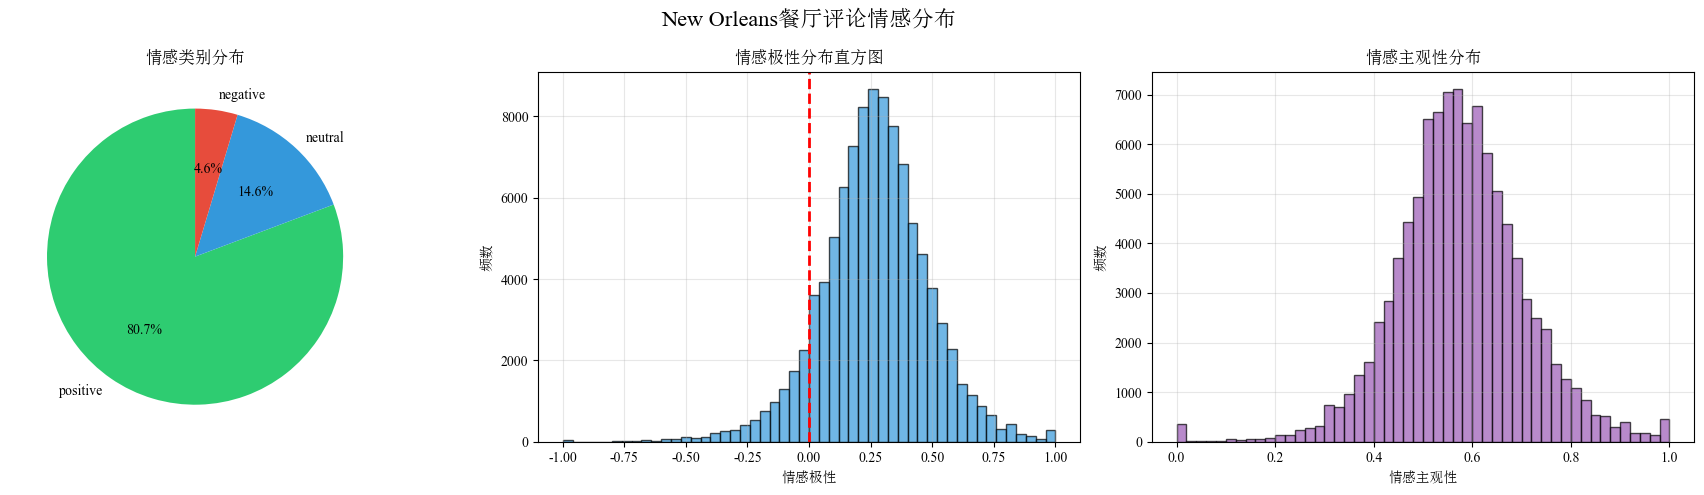

积极评论比例: 80.73%
消极评论比例: 4.63%
中性评论比例: 14.64%
平均情感极性: 0.2663
平均情感主观性: 0.5751

词云和关键词分析...
生成词云...


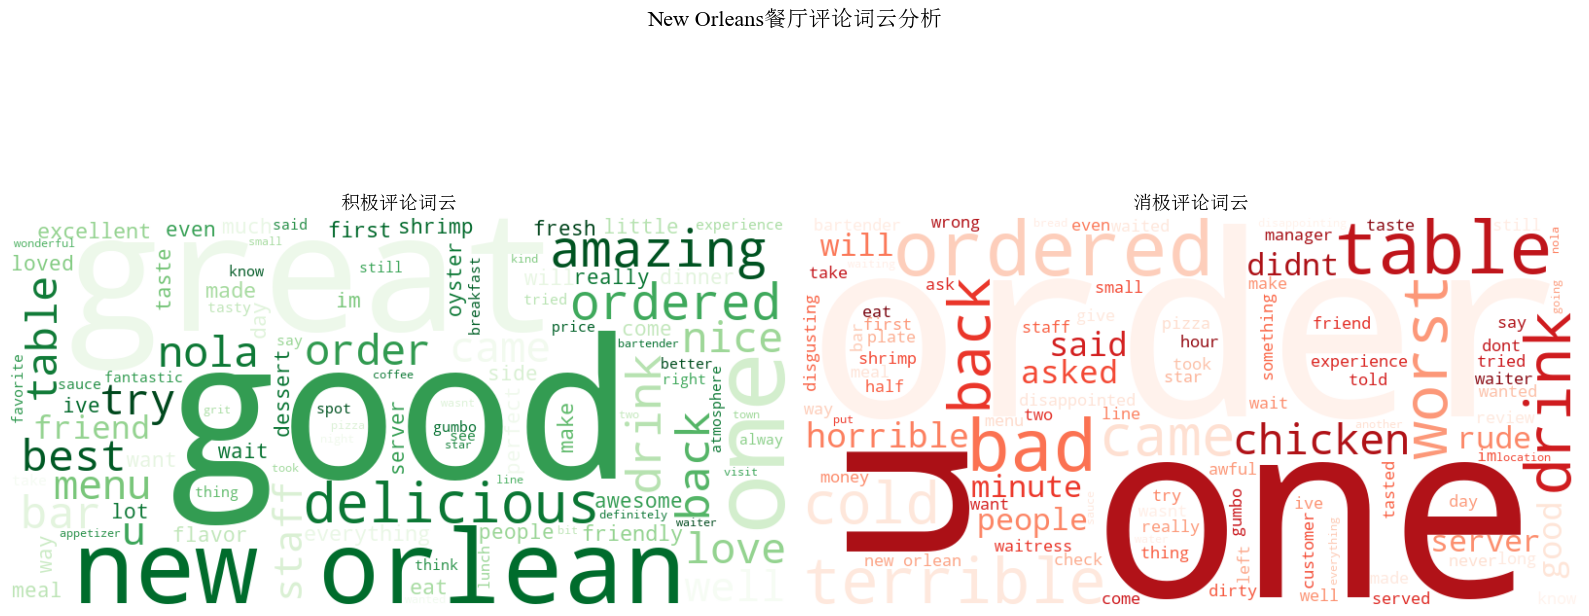

积极评论高频关键词:
  good: 47125
  great: 43824
  delicious: 19990
  best: 19941
  back: 19521
  really: 19270
  orleans: 17350
  amazing: 15824
  nice: 15061
  will: 14968

消极评论高频关键词:
  order: 1075
  never: 1000
  chicken: 962
  worst: 956
  ordered: 939
  back: 939
  even: 910
  dont: 903
  terrible: 815
  minutes: 792

顶级餐厅排名分析...


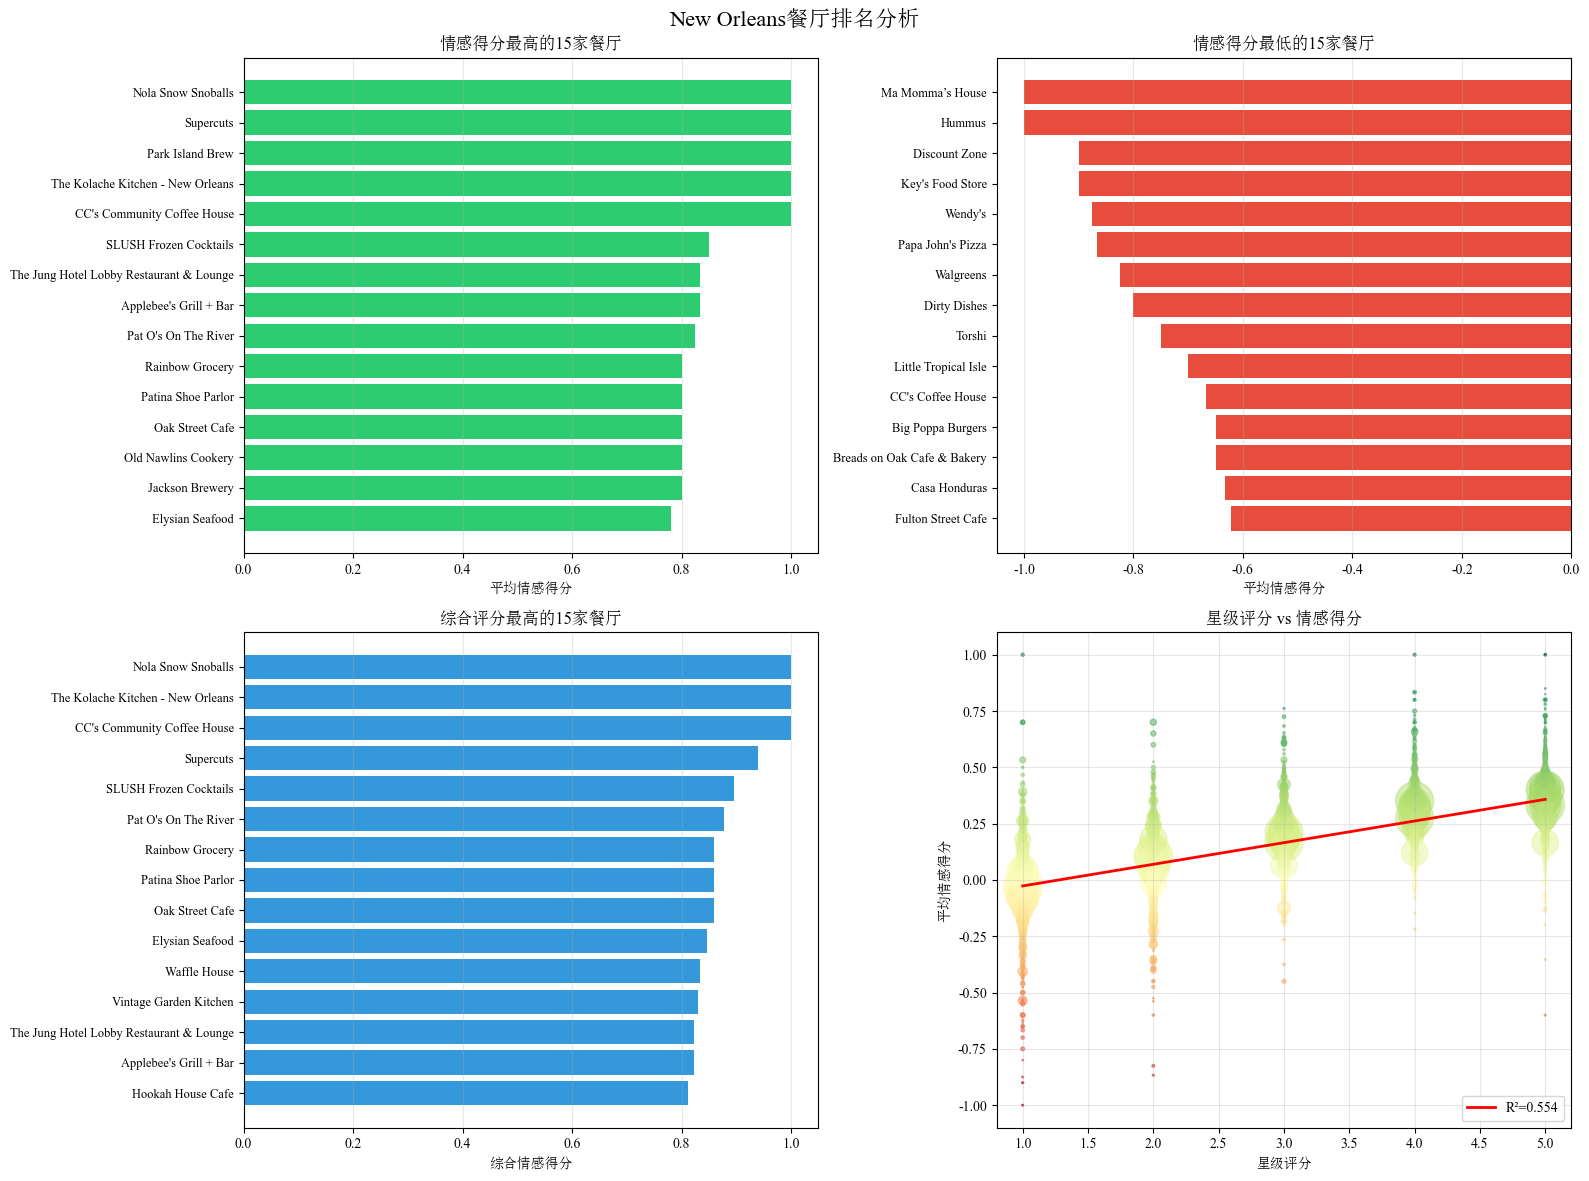

星级与情感得分的相关系数: 0.7440
R²值: 0.5536
回归方程: y = 0.0961x + -0.1226

空间分析...
进行空间分析...
发现 25 个情感热点区域
发现 25 个情感冷点区域


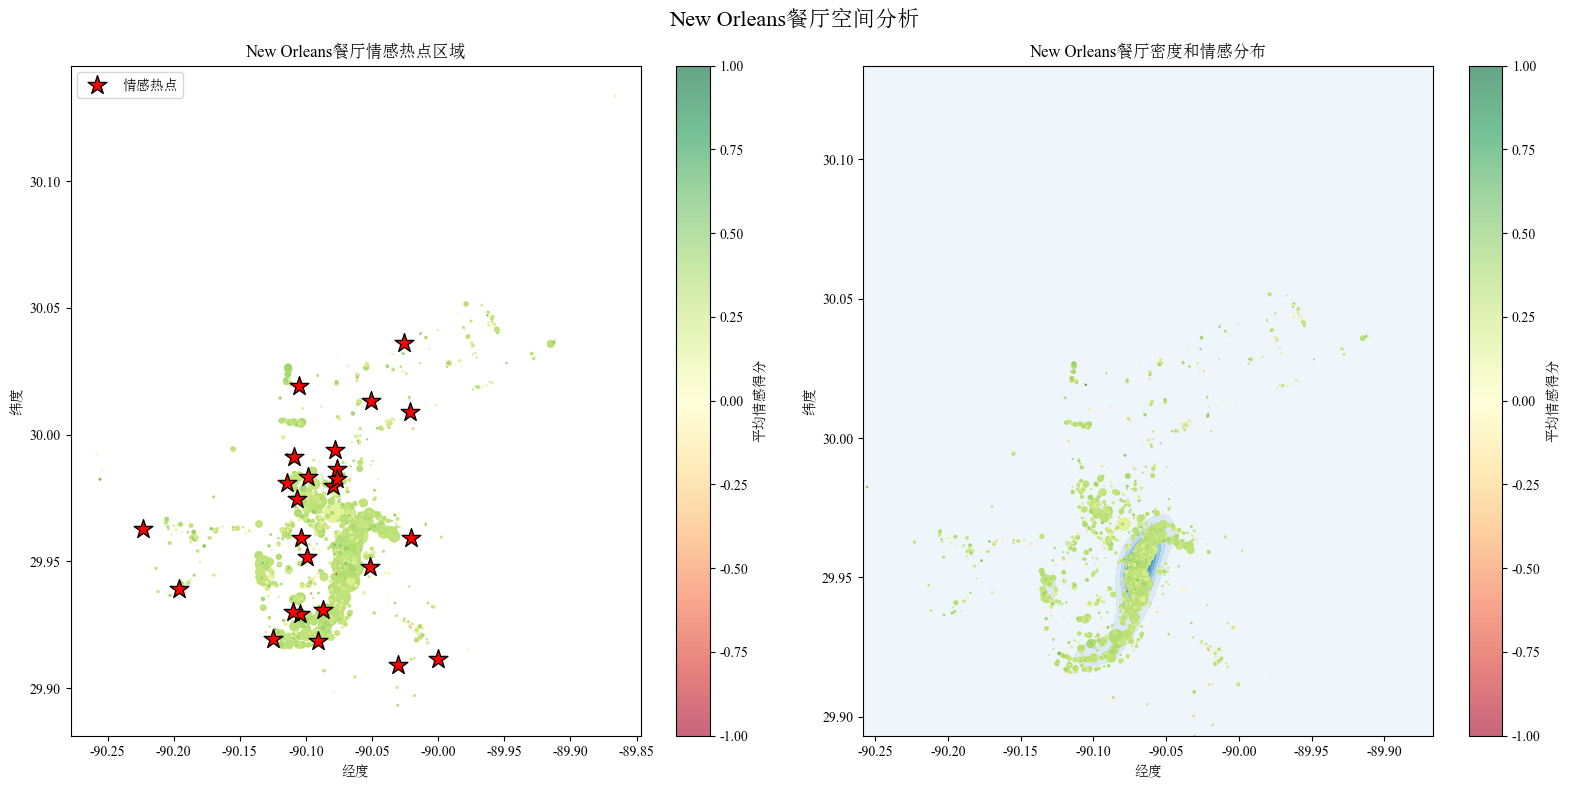


创建交互式地图...
创建情感分析地图...
地图已保存到: ./intermediate_data/sentiment_map_New_Orleans.html

创建交互式图表...
创建交互式可视化...
交互式图表已保存到: ['./intermediate_data/3d_scatter_New_Orleans.html', './intermediate_data/stars_vs_sentiment_New_Orleans.html', './intermediate_data/sentiment_distribution_New_Orleans.html']


In [21]:
# 6. 数据可视化
print("\n" + "=" * 60)
print("开始数据可视化...")

# 6.1 情感分布可视化
print("\n情感分布可视化...")
sentiment_stats = plot_sentiment_distribution(
sentiment_df, 
title=f"{TARGET_CITY}餐厅评论情感分布"
)

# 6.2 词云和关键词分析
print("\n词云和关键词分析...")
positive_keywords, negative_keywords = generate_wordclouds(sentiment_df)

# 6.3 顶级餐厅排名
print("\n顶级餐厅排名分析...")
top_restaurants_analysis = plot_top_restaurants(restaurant_stats, top_n=15)

# 6.4 空间分析
print("\n空间分析...")
spatial_analysis_results = spatial_analysis(restaurant_stats)

# 6.5 创建交互式地图
print("\n创建交互式地图...")
sentiment_map = create_sentiment_map(restaurant_stats)

# 6.6 创建交互式图表
print("\n创建交互式图表...")
interactive_plots = create_interactive_plots(restaurant_stats)

## 8. 分析报告生成和提示词构建

In [22]:
def generate_analysis_summary(analysis_results):
    """
    生成分析摘要，用于LLM报告生成
    """
    summary = {
        'city': TARGET_CITY,
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'overview': {},
        'sentiment_stats': {},
        'spatial_insights': {},
        'top_restaurants': {},
        'recommendations': {}
    }
    
    # 填充概览信息
    if 'business_count' in analysis_results:
        summary['overview']['total_restaurants'] = analysis_results['business_count']
    
    if 'review_count' in analysis_results:
        summary['overview']['total_reviews'] = analysis_results['review_count']
    
    # 填充情感统计
    if 'sentiment_stats' in analysis_results:
        summary['sentiment_stats'] = analysis_results['sentiment_stats']
    
    # 填充空间洞察
    if 'spatial_analysis' in analysis_results:
        summary['spatial_insights']['hotspot_count'] = len(analysis_results['spatial_analysis']['hotspots'])
        summary['spatial_insights']['coldspot_count'] = len(analysis_results['spatial_analysis']['coldspots'])
    
    # 填充顶级餐厅信息
    if 'top_restaurants_analysis' in analysis_results:
        top_positive_names = analysis_results['top_restaurants_analysis']['top_positive']['name'].tolist()[:5]
        top_negative_names = analysis_results['top_restaurants_analysis']['top_negative']['name'].tolist()[:5]
        
        summary['top_restaurants']['top_5_positive'] = top_positive_names
        summary['top_restaurants']['top_5_negative'] = top_negative_names
    
    return summary

def create_llm_prompt(analysis_summary):
    """
    创建用于LLM生成报告的提示词
    """
    prompt = f"""
# Yelp餐厅评论情感分析报告生成提示

## 研究背景
基于Yelp公开数据集，对{TARGET_CITY}的餐厅评论进行情感分析。研究时间为{analysis_summary['analysis_date']}。

## 关键发现
请基于以下分析结果，生成一份专业的餐厅情感分析报告：

### 1. 总体概况
- 分析餐厅数量: {analysis_summary.get('overview', {}).get('total_restaurants', 'N/A')}
- 分析评论数量: {analysis_summary.get('overview', {}).get('total_reviews', 'N/A')}

### 2. 情感分析结果
- 积极评论比例: {analysis_summary.get('sentiment_stats', {}).get('positive_percentage', 0):.1f}%
- 消极评论比例: {analysis_summary.get('sentiment_stats', {}).get('negative_percentage', 0):.1f}%
- 中性评论比例: {analysis_summary.get('sentiment_stats', {}).get('neutral_percentage', 0):.1f}%
- 平均情感极性: {analysis_summary.get('sentiment_stats', {}).get('avg_polarity', 0):.3f}
- 平均情感主观性: {analysis_summary.get('sentiment_stats', {}).get('avg_subjectivity', 0):.3f}

### 3. 空间洞察
- 发现情感热点区域数量: {analysis_summary.get('spatial_insights', {}).get('hotspot_count', 0)}
- 发现情感冷点区域数量: {analysis_summary.get('spatial_insights', {}).get('coldspot_count', 0)}

### 4. 顶级餐厅
情感得分最高的5家餐厅:
{chr(10).join([f'- {name}' for name in analysis_summary.get('top_restaurants', {}).get('top_5_positive', [])])}

情感得分最低的5家餐厅:
{chr(10).join([f'- {name}' for name in analysis_summary.get('top_restaurants', {}).get('top_5_negative', [])])}

## 报告要求
请生成一份包含以下部分的专业分析报告：

### 1. 执行摘要 (Executive Summary)
- 研究目的和主要发现概述
- 关键数据和洞察总结

### 2. 方法论 (Methodology)
- 数据来源和处理流程
- 情感分析技术（TextBlob）
- 空间分析方法

### 3. 数据分析结果 (Data Analysis Results)
#### 3.1 总体情感分布
- 积极/消极/中性评论的比例分析
- 情感极性的分布特征

#### 3.2 空间分析洞察
- 情感热点区域的特征和可能的商业机会
- 情感冷点区域的问题分析和改进建议
- 地理分布与城市功能区划的关系

#### 3.3 餐厅表现分析
- 顶级餐厅的成功因素分析
- 表现不佳餐厅的共性问题和改进建议

### 4. 商业启示 (Business Implications)
#### 4.1 对于餐厅经营者的建议
- 基于情感分析的服务改进策略
- 地理位置选择的优化建议

#### 4.2 对于投资者的机会
- 潜在的美食区投资机会
- 新兴餐饮趋势识别

#### 4.3 对于消费者的价值
- 基于情感分析的餐厅推荐策略
- 避免"游客陷阱"的实用建议

### 5. 局限性分析 (Limitations)
- 数据偏倚问题（如删除无坐标数据的影响）
- 情感分析技术的局限性
- 研究范围的限制

### 6. 未来研究方向 (Future Research)
- 扩展研究范围和时间跨度
- 结合更多维度的数据分析
- 推荐系统的优化方向

## 特别思考题
请在报告中深入探讨以下问题：

1. **情感热点与新兴美食区**：分析中发现的情感热点区域是否预示着新兴美食区或"网红"打卡地的形成？这些区域的餐厅类别、价格水平和商业模式有何特点？

2. **游客陷阱识别**：在游客密集区域出现的情感冷点，是否暗示了"游客陷阱"的存在？这些餐厅的评论中频繁提及的问题是什么？

3. **功能区划关联**：情感分布与城市功能区划之间是否存在关联？例如，商业区的餐厅情感与居民区的餐厅情感是否存在系统性差异？

## 报告格式要求
- 专业、客观的分析语气
- 数据驱动的论证方式
- 清晰的结构和逻辑
- 具体的商业建议
- 考虑目标读者：餐饮行业从业者、投资者、城市管理者

请基于以上分析结果和思考框架，生成一份完整的、有洞察力的分析报告。
    """
    
    # 保存提示词到文件
    prompt_file = os.path.join(INTERMEDIATE_PATH, f"llm_prompt_{TARGET_CITY.replace(' ', '_')}.txt")
    with open(prompt_file, 'w', encoding='utf-8') as f:
        f.write(prompt)
    
    print(f"LLM提示词已保存到: {prompt_file}")
    
    return prompt


In [23]:

# 7. 生成分析摘要和LLM提示词
print("\n" + "=" * 60)
print("生成分析摘要和LLM提示词...")

# 收集分析结果
analysis_results = {
    'business_count': len(business_df),
    'review_count': len(review_df),
    'sentiment_stats': sentiment_stats,
    'positive_keywords': positive_keywords,
    'negative_keywords': negative_keywords,
    'top_restaurants_analysis': top_restaurants_analysis,
    'spatial_analysis': spatial_analysis_results
}

# 生成分析摘要
analysis_summary = generate_analysis_summary(analysis_results)

# 生成LLM提示词
llm_prompt = create_llm_prompt(analysis_summary)

print("\n" + "=" * 60)
print("分析完成!")
print("\n主要成果:")
print(f"1. 餐厅情感分析结果已保存到: {INTERMEDIATE_PATH}")
print(f"2. 可视化图表已生成")
print(f"3. 交互式地图已保存")
print(f"4. LLM提示词已生成")
print("\n下一步:")
print("1. 复制LLM提示词到ChatGPT等工具")
print("2. 生成专业的分析报告")
print("3. 基于报告撰写实习报告")

# 打印关键数据用于报告
print("\n关键数据:")
print(f"- 分析餐厅数量: {len(business_df)}")
print(f"- 分析评论数量: {len(review_df)}")
print(f"- 积极评论比例: {sentiment_stats['positive_percentage']:.1f}%")
print(f"- 消极评论比例: {sentiment_stats['negative_percentage']:.1f}%")
print(f"- 情感最强餐厅: {top_restaurants_analysis['top_positive']['name'].iloc[0]}")
print(f"- 情感最弱餐厅: {top_restaurants_analysis['top_negative']['name'].iloc[0]}")



生成分析摘要和LLM提示词...
LLM提示词已保存到: ./intermediate_data/llm_prompt_New_Orleans.txt

分析完成!

主要成果:
1. 餐厅情感分析结果已保存到: ./intermediate_data/
2. 可视化图表已生成
3. 交互式地图已保存
4. LLM提示词已生成

下一步:
1. 复制LLM提示词到ChatGPT等工具
2. 生成专业的分析报告
3. 基于报告撰写实习报告

关键数据:
- 分析餐厅数量: 3343
- 分析评论数量: 270176
- 积极评论比例: 80.7%
- 消极评论比例: 4.6%
- 情感最强餐厅: Nola Snow Snoballs
- 情感最弱餐厅: Ma Momma’s House


## 9. 主执行流程

开始执行基于Yelp评论的餐厅推荐系统情感分析
目标城市: New Orleans
中间数据不存在，开始原始数据处理...
开始加载business数据: D:/必须用电脑解决的作业/地理大数据分析/实习四/实习四数据/yelp/yelp_academic_dataset_business.json
已加载 50000 条business数据
已加载 100000 条business数据
已加载 150000 条business数据
成功加载 150346 条business数据
过滤城市: New Orleans
过滤后剩余 6217 条数据（目标城市）
过滤餐厅数据...
过滤后剩余 3343 条餐厅数据
清洗坐标数据...
坐标清洗后剩余 3343 条数据
Business数据已保存到: ./intermediate_data/business_New_Orleans.csv
开始加载review数据，目标business数量: 3343
已扫描 500000 行review数据
已处理 547471 行，找到 50000 条相关评论
已扫描 1000000 行review数据
已处理 1276363 行，找到 50000 条相关评论
已扫描 1500000 行review数据
已处理 1936861 行，找到 50000 条相关评论
已扫描 2000000 行review数据
已扫描 2500000 行review数据
已处理 2579213 行，找到 50000 条相关评论
已扫描 3000000 行review数据
已处理 3193511 行，找到 50000 条相关评论
已扫描 3500000 行review数据
已处理 3839686 行，找到 50000 条相关评论
已扫描 4000000 行review数据
已处理 4460385 行，找到 50000 条相关评论
已扫描 4500000 行review数据
已扫描 5000000 行review数据
已处理 5061564 行，找到 50000 条相关评论
已扫描 5500000 行review数据
已处理 5689642 行，找到 50000 条相关评论
已扫描 6000000 行review数据
已处理 6429989 行，找到 50000 条相关评论
已扫描 6500000 行review

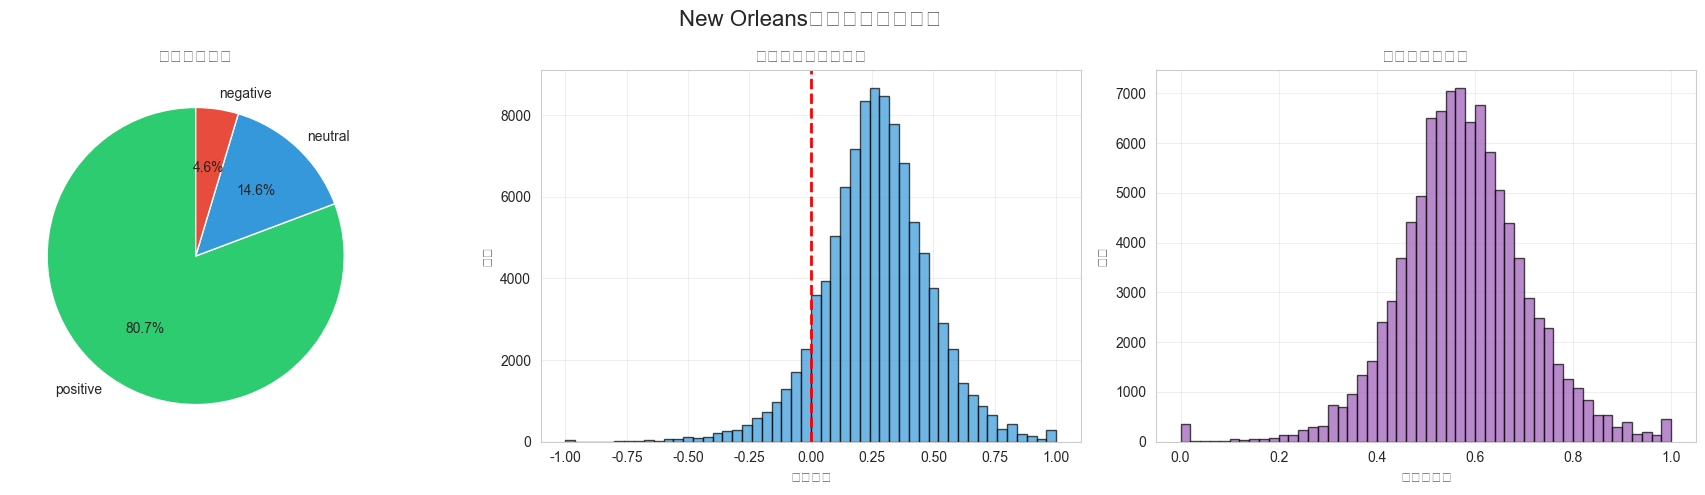

积极评论比例: 80.73%
消极评论比例: 4.63%
中性评论比例: 14.64%
平均情感极性: 0.2663
平均情感主观性: 0.5751

词云和关键词分析...
生成词云...


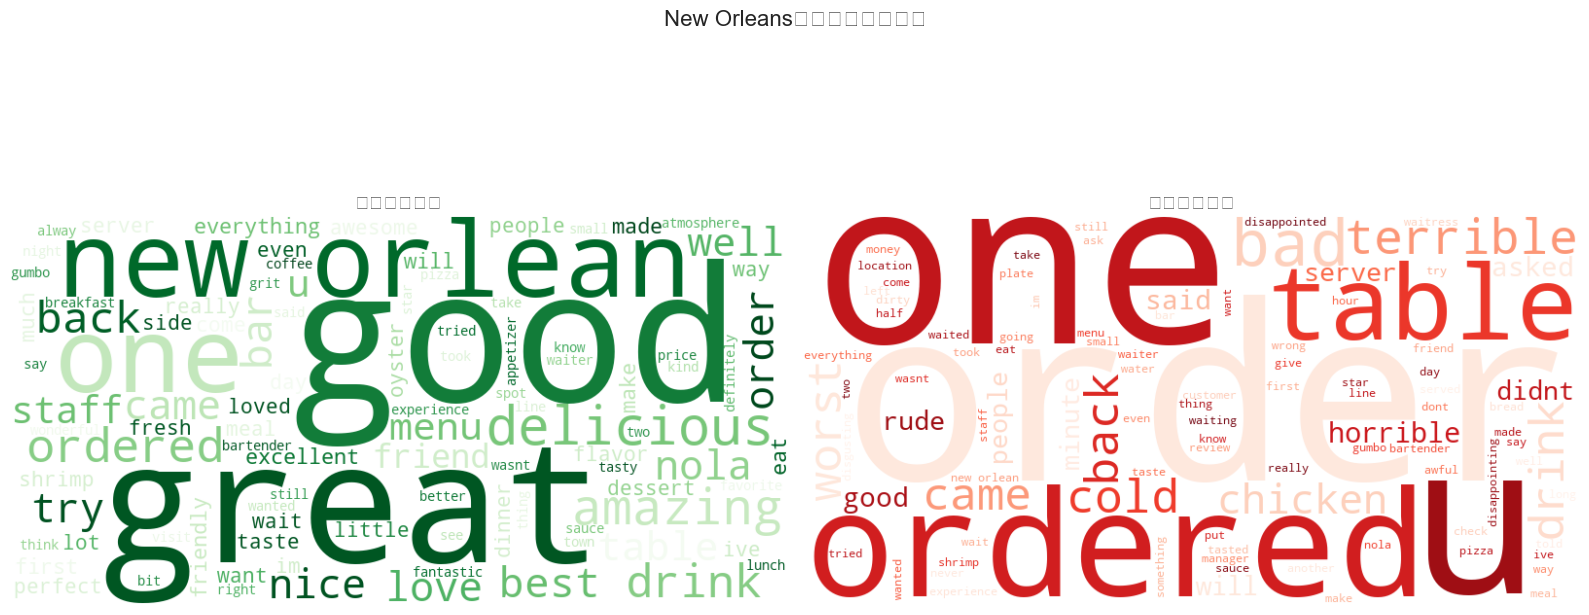

积极评论高频关键词:
  good: 47125
  great: 43824
  delicious: 19990
  best: 19941
  back: 19521
  really: 19270
  orleans: 17350
  amazing: 15824
  nice: 15061
  will: 14968

消极评论高频关键词:
  order: 1075
  never: 1000
  chicken: 962
  worst: 956
  ordered: 939
  back: 939
  even: 910
  dont: 903
  terrible: 815
  minutes: 792

顶级餐厅排名分析...


KeyError: 'avg_sentiment'

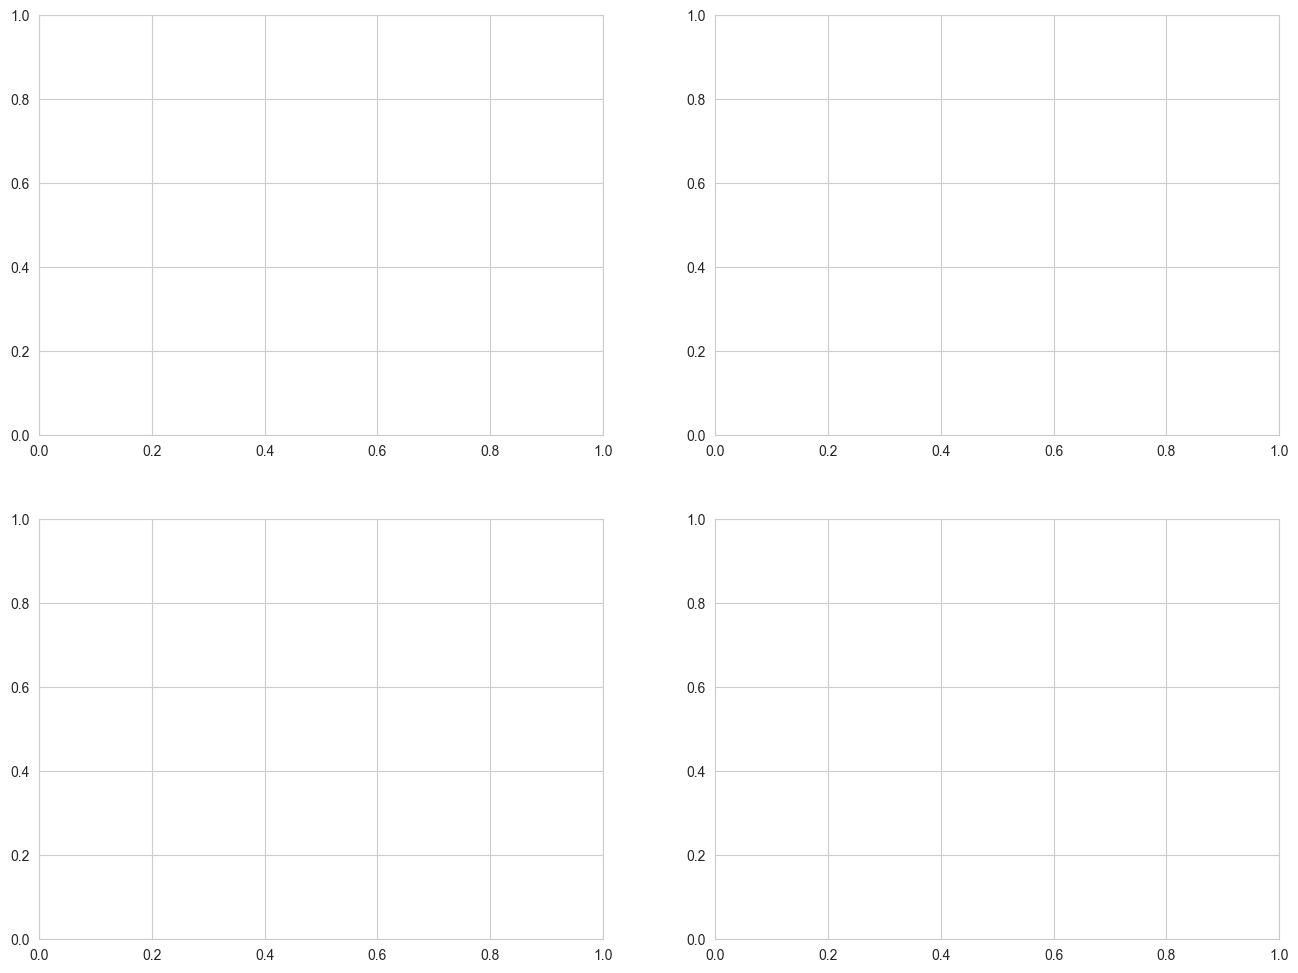

In [ ]:
def main():
    """
    主执行函数
    """
    print("=" * 60)
    print(f"开始执行基于Yelp评论的餐厅推荐系统情感分析")
    print(f"目标城市: {TARGET_CITY}")
    print("=" * 60)
    
    # 尝试加载中间数据
    business_df, review_df, merged_df = load_intermediate_data()
    
    if business_df is None or review_df is None:
        print("中间数据不存在，开始原始数据处理...")
        
        # 1. 加载business数据
        business_df = load_business_data(
            BUSINESS_FILE, 
            target_city=TARGET_CITY, 
            is_restaurant=True
        )
        
        if len(business_df) == 0:
            print(f"错误：未找到{TARGET_CITY}的餐厅数据")
            return
        
        # 2. 加载review数据（只加载相关business的评论）
        business_ids = business_df['business_id'].tolist()
        review_df = load_review_data(
            REVIEW_FILE, 
            business_ids, 
            sample_frac=0.5  # 采样50%以减少处理时间
        )
        
        if len(review_df) == 0:
            print("错误：未找到相关评论数据")
            return
        
        # 3. 合并数据
        merged_df = clean_and_merge_data(business_df, review_df)
    
    print(f"数据加载完成:")
    print(f"  餐厅数量: {len(business_df)}")
    print(f"  评论数量: {len(review_df)}")
    print(f"  合并数据形状: {merged_df.shape}")
    
    # 4. 情感分析
    print("\n" + "=" * 60)
    print("开始情感分析...")
    
    # 如果已经有情感分析结果，直接加载
    sentiment_file = os.path.join(INTERMEDIATE_PATH, "sentiment_analysis_results.csv")
    if os.path.exists(sentiment_file):
        print("加载已保存的情感分析结果...")
        sentiment_df = pd.read_csv(sentiment_file)
    else:
        # 进行情感分析（如果数据量大，可以采样）
        sample_size = min(100000, len(merged_df))  # 最多分析10万条评论
        sentiment_df = batch_sentiment_analysis(merged_df, sample_size=sample_size)
    
    # 5. 餐厅情感聚合
    print("\n" + "=" * 60)
    print("餐厅情感聚合...")
    
    restaurant_stats_file = os.path.join(INTERMEDIATE_PATH, "restaurant_sentiment_stats.csv")
    if os.path.exists(restaurant_stats_file):
        print("加载已保存的餐厅情感统计...")
        restaurant_stats = pd.read_csv(restaurant_stats_file)
    else:
        restaurant_stats = aggregate_restaurant_sentiments(sentiment_df)
    
    # 6. 数据可视化
    print("\n" + "=" * 60)
    print("开始数据可视化...")
    
    # 6.1 情感分布可视化
    print("\n情感分布可视化...")
    sentiment_stats = plot_sentiment_distribution(
        sentiment_df, 
        title=f"{TARGET_CITY}餐厅评论情感分布"
    )
    
    # 6.2 词云和关键词分析
    print("\n词云和关键词分析...")
    positive_keywords, negative_keywords = generate_wordclouds(sentiment_df)
    
    # 6.3 顶级餐厅排名
    print("\n顶级餐厅排名分析...")
    top_restaurants_analysis = plot_top_restaurants(restaurant_stats, top_n=15)
    
    # 6.4 空间分析
    print("\n空间分析...")
    spatial_analysis_results = spatial_analysis(restaurant_stats)
    
    # 6.5 创建交互式地图
    print("\n创建交互式地图...")
    sentiment_map = create_sentiment_map(restaurant_stats)
    
    # 6.6 创建交互式图表
    print("\n创建交互式图表...")
    interactive_plots = create_interactive_plots(restaurant_stats)
    
    # 7. 生成分析摘要和LLM提示词
    print("\n" + "=" * 60)
    print("生成分析摘要和LLM提示词...")
    
    # 收集分析结果
    analysis_results = {
        'business_count': len(business_df),
        'review_count': len(review_df),
        'sentiment_stats': sentiment_stats,
        'positive_keywords': positive_keywords,
        'negative_keywords': negative_keywords,
        'top_restaurants_analysis': top_restaurants_analysis,
        'spatial_analysis': spatial_analysis_results
    }
    
    # 生成分析摘要
    analysis_summary = generate_analysis_summary(analysis_results)
    
    # 生成LLM提示词
    llm_prompt = create_llm_prompt(analysis_summary)
    
    print("\n" + "=" * 60)
    print("分析完成!")
    print("\n主要成果:")
    print(f"1. 餐厅情感分析结果已保存到: {INTERMEDIATE_PATH}")
    print(f"2. 可视化图表已生成")
    print(f"3. 交互式地图已保存")
    print(f"4. LLM提示词已生成")
    print("\n下一步:")
    print("1. 复制LLM提示词到ChatGPT等工具")
    print("2. 生成专业的分析报告")
    print("3. 基于报告撰写实习报告")
    
    # 打印关键数据用于报告
    print("\n关键数据:")
    print(f"- 分析餐厅数量: {len(business_df)}")
    print(f"- 分析评论数量: {len(review_df)}")
    print(f"- 积极评论比例: {sentiment_stats['positive_percentage']:.1f}%")
    print(f"- 消极评论比例: {sentiment_stats['negative_percentage']:.1f}%")
    print(f"- 情感最强餐厅: {top_restaurants_analysis['top_positive']['name'].iloc[0]}")
    print(f"- 情感最弱餐厅: {top_restaurants_analysis['top_negative']['name'].iloc[0]}")
    
    return analysis_results

# if __name__ == "__main__":
#     # 执行主函数
#     results = main()


## 10. 辅助函数和清理代码

In [ ]:
def export_results_for_report():
    """
    导出用于报告的关键结果
    """
    print("导出关键结果用于报告...")
    
    # 读取关键文件
    files_to_export = [
        "restaurant_sentiment_stats.csv",
        "sentiment_analysis_results.csv"
    ]
    
    export_data = {}
    
    for file in files_to_export:
        file_path = os.path.join(INTERMEDIATE_PATH, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            export_data[file.replace('.csv', '')] = df.head(100)  # 只导出前100行
            
            print(f"已加载: {file} ({len(df)} 行)")
    
    # 生成关键统计数据
    if 'restaurant_sentiment_stats' in export_data:
        stats_df = export_data['restaurant_sentiment_stats']
        
        key_stats = {
            'total_restaurants': len(stats_df),
            'avg_sentiment_overall': stats_df['avg_sentiment'].mean(),
            'median_sentiment': stats_df['avg_sentiment'].median(),
            'std_sentiment': stats_df['avg_sentiment'].std(),
            'top_10_restaurants': stats_df.nlargest(10, 'avg_sentiment')[['name', 'avg_sentiment', 'stars']].to_dict('records'),
            'bottom_10_restaurants': stats_df.nsmallest(10, 'avg_sentiment')[['name', 'avg_sentiment', 'stars']].to_dict('records')
        }
        
        # 保存关键统计数据
        import json
        stats_file = os.path.join(INTERMEDIATE_PATH, "key_statistics.json")
        with open(stats_file, 'w', encoding='utf-8') as f:
            json.dump(key_stats, f, ensure_ascii=False, indent=2)
        
        print(f"关键统计数据已保存到: {stats_file}")
    
    return export_data

def create_final_report_package():
    """
    创建最终提交的报告包
    """
    print("创建最终报告包...")
    
    import shutil
    import zipfile
    
    # 创建提交目录
    submission_dir = f"./submission_{TARGET_CITY.replace(' ', '_')}"
    os.makedirs(submission_dir, exist_ok=True)
    
    # 需要包含的文件
    files_to_include = [
        # 代码文件
        "main.ipynb",  # 假设这是你的Jupyter笔记本文件
        
        # 中间数据文件（关键部分）
        os.path.join(INTERMEDIATE_PATH, "restaurant_sentiment_stats.csv"),
        os.path.join(INTERMEDIATE_PATH, "sentiment_analysis_results.csv"),
        os.path.join(INTERMEDIATE_PATH, "key_statistics.json"),
        
        # 可视化文件
        os.path.join(INTERMEDIATE_PATH, f"sentiment_map_{TARGET_CITY.replace(' ', '_')}.html"),
        os.path.join(INTERMEDIATE_PATH, f"3d_scatter_{TARGET_CITY.replace(' ', '_')}.html"),
        os.path.join(INTERMEDIATE_PATH, f"stars_vs_sentiment_{TARGET_CITY.replace(' ', '_')}.html"),
        
        # LLM提示词
        os.path.join(INTERMEDIATE_PATH, f"llm_prompt_{TARGET_CITY.replace(' ', '_')}.txt"),
        
        # 可能生成的图像文件
        os.path.join(INTERMEDIATE_PATH, "visualizations/")
    ]
    
    # 复制文件到提交目录
    for file_path in files_to_include:
        if os.path.exists(file_path):
            if os.path.isdir(file_path):
                # 如果是目录，复制整个目录
                dest_dir = os.path.join(submission_dir, os.path.basename(file_path))
                if os.path.exists(dest_dir):
                    shutil.rmtree(dest_dir)
                shutil.copytree(file_path, dest_dir)
            else:
                # 如果是文件，复制文件
                shutil.copy2(file_path, submission_dir)
    
    # 创建压缩包
    zip_filename = f"学号_姓名_地理大数据分析实习4_{TARGET_CITY.replace(' ', '_')}.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(submission_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, submission_dir)
                zipf.write(file_path, arcname)
    
    print(f"提交包已创建: {zip_filename}")
    print(f"请将 {zip_filename} 提交给学委")
    
    return zip_filename
